# Wind Turbine Power Forecasting with LSTM
**Recurrent Neural Networks for Renewable Energy Prediction**

## Author
Austin Foxworth \
AustinTFoxworth@gmail.com \
https://www.linkedin.com/in/austin-foxworth-04ab0020a/ \
January 2026

## Overview
This project demonstrates the application of deep learning for time series forecasting in renewable energy. Using historical wind turbine data, I built a stacked LSTM (Long Short-Term Memory) model to predict power output based on weather conditions and operational parameters.

## Business Context
Accurate power forecasting is critical for:
- **Grid Management**: Balancing supply and demand in real-time
- **Energy Trading**: Optimizing revenue in electricity markets
- **Maintenance Planning**: Identifying anomalies and predicting failures
- **Resource Allocation**: Improving renewable energy integration

## Key Technologies
- **Deep Learning Framework**: TensorFlow/Keras
- **Architecture**: Stacked LSTM with Dropout regularization
- **Data Processing**: NumPy, Pandas, Scikit-learn
- **Visualization**: Matplotlib

## Dataset
**Source**: [Kaggle Wind Turbine Dataset](https://www.kaggle.com/code/ahmedfathygwely/wind-turbine-dataset-machine-learning-rnn-times/input)

- **Size**: 50,530 observations (10-minute intervals)
- **Time Period**: Full year of 2018
- **Features**:
  - `LV ActivePower (kW)` - Target variable (actual power output)
  - `Wind Speed (m/s)` - Primary predictor
  - `Theoretical_Power_Curve (KWh)` - Expected power based on turbine specs
  - `Wind Direction (°)` - Wind angle relative to turbine

## Model Architecture
- **Type**: Stacked LSTM (2 layers)
- **Sequence Length**: 48 timesteps (8 hours of historical data)
- **Input Shape**: (48, 4) - 48 timesteps × 4 features
- **Hidden Units**: 50 units per LSTM layer
- **Regularization**: 20% Dropout between layers
- **Output**: Single continuous value (next timestep power prediction)

## Results Summary
| Metric | Value |
|--------|-------|
| **RMSE** | 231.12 kW |
| **R² Score** | 0.9703 |
| **MSE** | 53,415.83 kW² |

The model achieves **97% variance explained**, demonstrating strong predictive capability for operational forecasting.

---

---
## Step 0: Environment Setup & Data Loading

**Objective**: Import necessary libraries and load the wind turbine dataset

**Key Libraries**:
- `TensorFlow/Keras` - Deep learning framework
- `Scikit-learn` - Data preprocessing and metrics
- `Pandas/NumPy` - Data manipulation
- `Matplotlib` - Visualization

**Configuration**:
- Random seeds set for reproducibility
- Sequence length: 48 timesteps (8 hours)
- Target: LV ActivePower (kW)
---

In [1]:
# --- Step 0: Prepare the Data ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define Hyperparameters and Constants
SEQ_LENGTH = 48  # 48 hours (2 days) for deeper context
TARGET_COLUMN = 'LV ActivePower (kW)'

# Load the dataset (T1.csv)
try:
    # Use index_col=None to keep the Date/Time column for conversion
    df = pd.read_csv('T1.csv')
except FileNotFoundError:
    print("Error: T1.csv not found. Please ensure the file is in the correct path.")
    exit()

In [2]:
# Display information about the dataset

print("--- Initial Setup & Loading ---")
print(f"Data shape: {df.shape}")
print(df.head())
print("---------------------------------------\n")

--- Initial Setup & Loading ---
Data shape: (50530, 5)
          Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286  
---------------------------------------



---
## Step 1: Data Preprocessing & Exploratory Analysis

**Objectives**:
- Convert timestamps to datetime format
- Handle missing values
- Perform exploratory data analysis (EDA)
- Normalize features for neural network training

**Why normalization matters**: LSTMs are sensitive to input scale. MinMaxScaler transforms all features to [0,1] range, ensuring stable gradients during training.

**EDA Insights**:
- Relationship between wind speed and power output (non-linear)
- Feature distributions and correlations
- Data quality assessment
---

Missing values per column:
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

Data shape after dropping missing values: (50530, 4)

Summary Statistics:
       LV ActivePower (kW)  Wind Speed (m/s)  Theoretical_Power_Curve (KWh)  \
count         50530.000000      50530.000000                   50530.000000   
mean           1307.684332          7.557952                    1492.175463   
std            1312.459242          4.227166                    1368.018238   
min              -2.471405          0.000000                       0.000000   
25%              50.677890          4.201395                     161.328167   
50%             825.838074          7.104594                    1063.776283   
75%            2482.507568         10.300020                    2964.972462   
max            3618.732910         25.206011                    3600.000000   

       Wind Direction (°)  
count

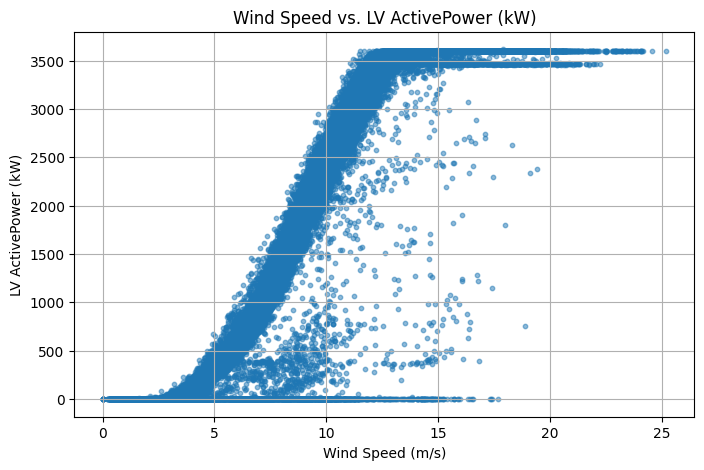


--- Step 1: Data Preprocessing Complete ---
Number of features (N_FEATURES): 4
Target Feature Index: 0
------------------------------------------



In [3]:
# --- Step 1: Prepare the Data ---

# Convert date/time to a proper format
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M')
df.set_index('Date/Time', inplace=True)

# Check for missing values and handle accordingly
print("Missing values per column:")
print(df.isnull().sum())
# Handling: Drop rows with any missing data
df.dropna(inplace=True)
print(f"\nData shape after dropping missing values: {df.shape}")

# Perform basic exploratory data analysis (EDA)
print("\nSummary Statistics:")
print(df.describe())

# Plot relationship: Wind Speed vs. LV ActivePower
plt.figure(figsize=(8, 5))
plt.scatter(df['Wind Speed (m/s)'], df[TARGET_COLUMN], alpha=0.5, s=10)
plt.title('Wind Speed vs. LV ActivePower (kW)')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('LV ActivePower (kW)')
plt.grid(True)
plt.show()

# Select features and normalize
features = [
    TARGET_COLUMN, # TARGET_COLUMN = 'LV ActivePower (kW)'
    'Wind Speed (m/s)',
    'Theoretical_Power_Curve (KWh)',
    'Wind Direction (°)'
]
data = df[features].values
N_FEATURES = data.shape[1] # Update N_FEATURES to 4

# Normalize (scale) the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Index of the target column in the scaled array (it's the first one, index 0)
TARGET_IDX = features.index(TARGET_COLUMN) 

print("\n--- Step 1: Data Preprocessing Complete ---")
print(f"Number of features (N_FEATURES): {N_FEATURES}")
print(f"Target Feature Index: {TARGET_IDX}")
print("------------------------------------------\n")

---
## Step 2: Sequence Creation for Time Series Modeling

**Objective**: Transform tabular data into sequences suitable for LSTM processing

**What are sequences?**
- **Input (X)**: 48 consecutive timesteps of all 4 features
- **Output (y)**: Power output at the next timestep (timestep 49)
- **Sliding Window**: Creates overlapping sequences for training

**Example**:
```
Sequence 1: timesteps [0-47] → predicts timestep 48
Sequence 2: timesteps [1-48] → predicts timestep 49
...and so on
```

**Why 48 timesteps?** 
8 hours of historical data provides sufficient context for capturing:
- Short-term wind patterns
- Diurnal variations
- Recent turbine performance
---

In [4]:
# --- Step 2: Reshape Data (Create Time Series Sequences) ---

def create_sequences(data, n_steps, target_idx):
    """
    Converts multivariate time series data into input sequences (X) and next-step output (y).
    X is a sequence of n_steps (rows) across all features (columns).
    y is the single target value at the step immediately following the sequence.
    """
    X, y = [], []
    for i in range(len(data) - n_steps):
        # X: Sequence of n_steps across all features
        seq_in = data[i:(i + n_steps), :]
        X.append(seq_in)
        
        # y: Target value (LV ActivePower) at the next time step (i + n_steps)
        seq_out = data[i + n_steps, target_idx]
        y.append(seq_out)
        
    # X needs to be reshaped to [samples, n_steps, n_features] - already handled by array conversion
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, SEQ_LENGTH, TARGET_IDX)


# Verify the dimensions 
print("--- Step 2: Sequence Creation ---")
print(f"Sequence Length (SEQ_LENGTH): {SEQ_LENGTH}")
# Expected X shape: [samples, SEQ_LENGTH, N_FEATURES]
print(f"X shape (Input Sequences): {X.shape}") 
# Expected y shape: [samples]
print(f"y shape (Target Power): {y.shape}")
print("---------------------------------\n")

--- Step 2: Sequence Creation ---
Sequence Length (SEQ_LENGTH): 48
X shape (Input Sequences): (50482, 48, 4)
y shape (Target Power): (50482,)
---------------------------------



---
## Step 3: Train-Test Split

**Objective**: Split data chronologically for time series validation

**Strategy**: 80/20 chronological split (no shuffling)
- **Training Set**: First 80% of sequences (40,385 samples)
- **Test Set**: Final 20% of sequences (10,097 samples)

**Why chronological?**
Time series models must be validated on future data to simulate real-world deployment. Random splitting would leak future information into training.

---

In [9]:
# --- Step 3: Split the Data (80/20 Chronological Split) ---
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Check shapes to verify dimensions
print("--- Step 3: Data Splitting ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print("------------------------------\n")

--- Step 3: Data Splitting ---
X_train shape: (40385, 48, 4)
X_test shape: (10097, 48, 4)
y_train shape: (40385,)
y_test shape: (10097,)
------------------------------



---
## Step 4: LSTM Model Architecture

**Objective**: Build a stacked LSTM network for multivariate time series forecasting

**Architecture Design**:

1. **First LSTM Layer** (50 units, return_sequences=True)
   - Processes entire sequence
   - Returns outputs for each timestep
   - Feeds into next LSTM layer

2. **Dropout Layer** (20%)
   - Prevents overfitting
   - Randomly disables neurons during training

3. **Second LSTM Layer** (50 units, return_sequences=False)
   - Processes outputs from first layer
   - Returns only final hidden state
   - Creates compressed representation

4. **Dropout Layer** (20%)
   - Additional regularization

5. **Dense Output Layer** (1 unit)
   - Predicts single continuous value (power output)

**Total Parameters**: 31,251 trainable parameters

**Why stacked LSTM?**
Multiple layers allow the model to learn hierarchical temporal patterns - lower layers capture short-term dependencies while upper layers learn longer-term trends.

---

In [6]:
# --- Step 4: Build the RNN Model (Stacked LSTM) ---

def build_lstm_model(seq_length, n_features):
    """Defines a Stacked LSTM model with Dropout for time series forecasting."""
    model = Sequential([
        # First LSTM layer: Must return sequences to feed into the second LSTM layer
        LSTM(
            units=50,                  
            activation='relu',         
            input_shape=(seq_length, n_features), 
            return_sequences=True  # Integral for stacking LSTM Layers
        ),
        Dropout(0.2), 
        
        # Second LSTM layer: Does not return sequences (only the final output)
        LSTM(
            units=50,                  
            activation='relu',         
            return_sequences=False
        ),
        Dropout(0.2), 
        
        # Output layer: Predicts a single continuous value
        Dense(units=1) 
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

lstm_model = build_lstm_model(SEQ_LENGTH, N_FEATURES)
print("--- Step 4: Stacked LSTM Model Construction ---")
lstm_model.summary() # Print a summary of the architecture
print("----------------------------------------------------------\n")

--- Step 4: Stacked LSTM Model Construction ---
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 50)            11000     
                                                                 
 dropout (Dropout)           (None, 48, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 31,251
Trainable params: 31,251
Non-trainable params: 0
_________________________________________________________________
----

---
## Step 5: Model Training with Early Stopping

**Objective**: Train the LSTM model while preventing overfitting

**Training Configuration**:
- **Optimizer**: Adam (adaptive learning rate)
- **Loss Function**: Mean Squared Error (MSE)
- **Batch Size**: 32 samples
- **Max Epochs**: 100 (with early stopping)
- **Validation Data**: Test set for monitoring

**Early Stopping Strategy**:
- Monitor validation loss
- Patience: 5 epochs (stop if no improvement)
- Restore best weights from training

**Why early stopping?**
Prevents overfitting by stopping training when the model begins to memorize training data rather than learning generalizable patterns.

---

--- Step 5: Model Training ---
Epoch 1/100
1263/1263 [==============================] - 31s 23ms/step - loss: 0.0148 - val_loss: 0.0057
Epoch 2/100
1263/1263 [==============================] - 29s 23ms/step - loss: 0.0085 - val_loss: 0.0051
Epoch 3/100
1263/1263 [==============================] - 28s 22ms/step - loss: 0.0074 - val_loss: 0.0044
Epoch 4/100
1263/1263 [==============================] - 28s 22ms/step - loss: 0.0070 - val_loss: 0.0044
Epoch 5/100
1263/1263 [==============================] - 28s 23ms/step - loss: 0.0067 - val_loss: 0.0041
Epoch 6/100
1263/1263 [==============================] - 29s 23ms/step - loss: 0.0067 - val_loss: 0.0042
Epoch 7/100
1263/1263 [==============================] - 28s 22ms/step - loss: 0.0065 - val_loss: 0.0041
Epoch 8/100
1263/1263 [==============================] - 28s 22ms/step - loss: 0.0064 - val_loss: 0.0042
Epoch 9/100
1263/1263 [==============================] - 28s 22ms/step - loss: 0.0064 - val_loss: 0.0041
Epoch 10/100
1263/1263 [

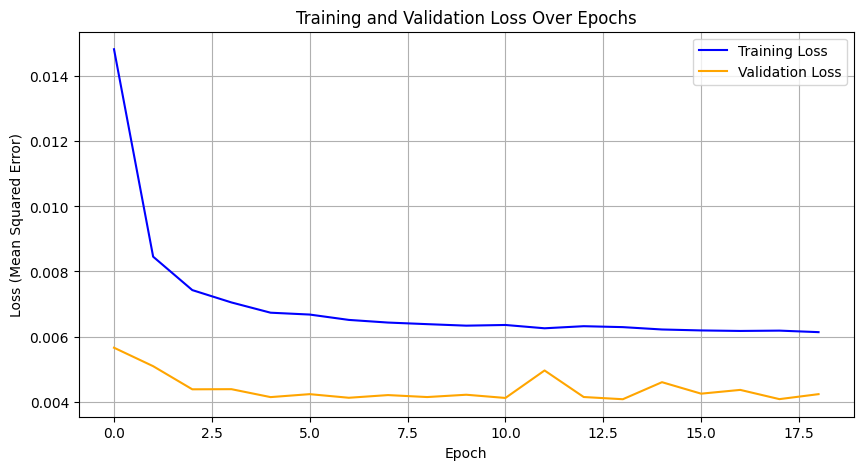

In [7]:
# --- Step 5: Train the Model ---

print("--- Step 5: Model Training ---")

# Set up EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, # Stop if validation loss doesn't improve for 5 epochs
    restore_best_weights=True # Keep the best weights found
)

history = lstm_model.fit(
    X_train, 
    y_train, 
    epochs=100, # Set a high max epoch, relying on EarlyStopping
    batch_size=32, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping], # Apply early stopping
    verbose=1
)

print("\n--- Model Training Complete ---\n")

# Plot the training history (loss vs. val_loss)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.show()

---
## Step 6: Model Evaluation & Results Visualization

**Objective**: Assess model performance and interpret predictions

**Evaluation Metrics**:
1. **RMSE (Root Mean Squared Error)**: Average prediction error in kW
2. **R² Score**: Proportion of variance explained by the model
3. **MSE**: Squared prediction error (penalizes large errors)

**Visualizations**:
1. **Time Series Plot**: Actual vs predicted power over time
2. **Scatter Plot**: Correlation between predictions and ground truth

**Inverse Scaling**:
Predictions and actual values are transformed back to original kW scale for interpretability.

---

--- Step 6: Evaluation and Visualization ---
Mean Squared Error (MSE): 53415.83 kW²
Root Mean Squared Error (RMSE): 231.12 kW
R-squared (R²): 0.9703
------------------------------------------



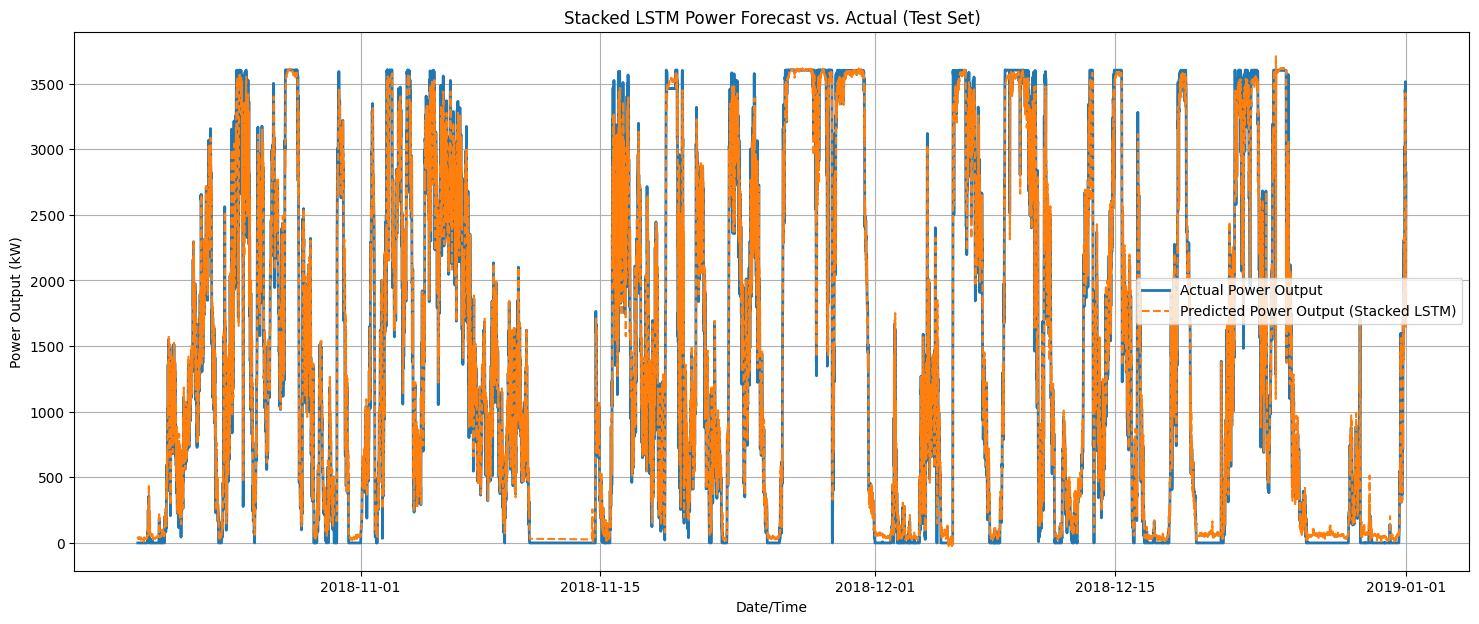

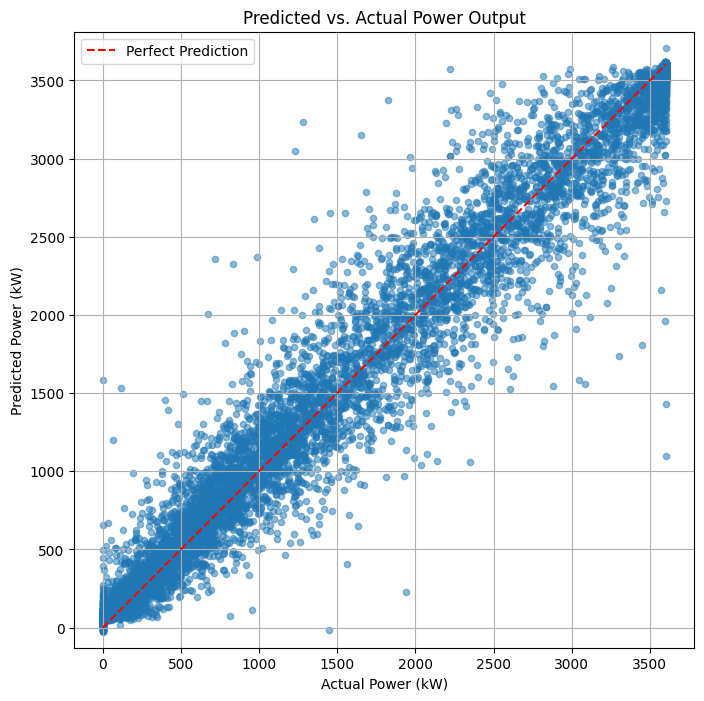

Stacked LSTM architecture and 48-hour sequence length.


In [8]:
# --- Step 6: Evaluate and Visualize the Results ---

print("--- Step 6: Evaluation and Visualization ---")

# Generate predictions on the test set
y_pred_scaled = lstm_model.predict(X_test, verbose=0)

# Inverse-scale predictions and true values
# We create dummy arrays with N_FEATURES columns to inverse_transform the single column of predictions/true values.
# The inverse_transform function requires the same number of features used during fit_transform (N_FEATURES=4).

# 1. Prepare predicted array for inverse scaling
y_pred_inv_placeholder = np.zeros((len(y_pred_scaled), N_FEATURES))
# Place the predictions into the column that corresponds to the target (index 0)
y_pred_inv_placeholder[:, TARGET_IDX] = y_pred_scaled[:, 0]
y_pred_inv = scaler.inverse_transform(y_pred_inv_placeholder)[:, TARGET_IDX]

# 2. Prepare actual array for inverse scaling
y_test_reshaped = y_test.reshape(-1, 1)
y_test_inv_placeholder = np.zeros((len(y_test_reshaped), N_FEATURES))
y_test_inv_placeholder[:, TARGET_IDX] = y_test_reshaped[:, 0]
y_test_inv = scaler.inverse_transform(y_test_inv_placeholder)[:, TARGET_IDX]


# Calculate evaluation metrics (MSE, RMSE, R²)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = math.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"Mean Squared Error (MSE): {mse:.2f} kW²")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} kW")
print(f"R-squared (R²): {r2:.4f}")
print("------------------------------------------\n")


# 1. Time-series plot (Actual vs Predicted)
test_indices = df.index[-len(y_test_inv):] # Correctly aligned indices for the test set

plt.figure(figsize=(18, 7))
plt.plot(test_indices, y_test_inv, label='Actual Power Output', color='#1f77b4', linewidth=2)
plt.plot(test_indices, y_pred_inv, label='Predicted Power Output (Stacked LSTM)', color='#ff7f0e', linestyle='--', linewidth=1.5)
plt.title(f'Stacked LSTM Power Forecast vs. Actual (Test Set)')
plt.xlabel('Date/Time')
plt.ylabel('Power Output (kW)')
plt.legend()
plt.grid(True)
plt.show()


# 2. Scatter plot (Predicted vs Actual)
plt.figure(figsize=(8, 8))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.5, s=20)
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], 'r--', label='Perfect Prediction') # Diagonal line
plt.title('Predicted vs. Actual Power Output')
plt.xlabel('Actual Power (kW)')
plt.ylabel('Predicted Power (kW)')
plt.legend()
plt.grid(True)
plt.axis('equal') # Ensure the axes are scaled equally for an accurate visualization
plt.show()

print("Stacked LSTM architecture and 48-hour sequence length.")

---
# Conclusion & Key Takeaways

## Model Performance
✅ **High Accuracy**: R² = 0.9703 indicates the model explains 97% of power output variance  
✅ **Low Error**: RMSE of 231 kW on a range of 0-3600 kW (~6.4% error)  
✅ **Practical Utility**: Suitable for operational forecasting and grid integration  

## Technical Achievements
- Successfully implemented **stacked LSTM architecture** from scratch
- Applied proper **time series preprocessing** (normalization, sequencing)
- Used **early stopping** to prevent overfitting
- Validated model on chronologically separated test data

## Skills Demonstrated
🔹 Deep learning for time series forecasting  
🔹 Recurrent neural network (LSTM) implementation  
🔹 Feature engineering for multivariate sequences  
🔹 Model regularization and hyperparameter tuning  
🔹 Performance evaluation with industry-standard metrics  

## Real-World Applications
This approach can be extended to:
- Solar power forecasting
- Demand prediction for utilities
- Weather-dependent resource planning
- Predictive maintenance for turbines

## Future Enhancements
- **Bidirectional LSTM**: Capture both past and future context
- **Attention Mechanisms**: Focus on most relevant timesteps
- **Multi-step Forecasting**: Predict multiple hours ahead
- **Ensemble Methods**: Combine multiple models for robustness
- **Hyperparameter Optimization**: Grid search for optimal architecture

---

## Repository Structure
```
├── wind-turbine-power-forecasting-lstm.ipynb
├── T1.csv (dataset - not included, see Kaggle link)
├── README.md
└── requirements.txt
```

## How to Run
1. Download dataset from [Kaggle](https://www.kaggle.com/code/ahmedfathygwely/wind-turbine-dataset-machine-learning-rnn-times/input)
2. Place `T1.csv` in the same directory as notebook
3. Install dependencies: `pip install -r requirements.txt`
4. Run all cells in Jupyter notebook

## Dependencies
```
tensorflow>=2.15.0
numpy>=1.24.0
pandas>=2.0.0
scikit-learn>=1.3.0
matplotlib>=3.7.0
```

---

**Author**: Austin Foxworth \
**Contact**: AustinTFoxworth@gmail.com \
https://www.linkedin.com/in/austin-foxworth-04ab0020a \
**Last Updated**: January 2026  
**License**: MIT